# The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. The dataset and more information can be founded [`here`](http://ufldl.stanford.edu/housenumbers/).

## Loading data and libraries

In [53]:
!pip install tqdm

In [54]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from urllib.request import urlretrieve
from os.path import isfile
from scipy.io import loadmat
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

%matplotlib inline
tf.reset_default_graph()

In [55]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('../data/train_32x32.mat'):
    os.mkdir('../data')
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Dataset') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            '../data/train_32x32.mat',
            pbar.hook)

svhn_data = loadmat('../data/train_32x32.mat')
print('Data loaded!')

Data loaded!


## Understanding the dataset

In [56]:
print(type(svhn_data))
print(svhn_data.keys())

<class 'dict'>
dict_keys(['X', 'y', '__header__', '__version__', '__globals__'])


In [57]:
features = svhn_data['X']
labels = svhn_data['y']

print('X: {} ({} x {} x {}) images'.format(features.shape[3], features.shape[0],
                                           features.shape[1], features.shape[2]))
print('y: {} ({}) labels'.format(labels.shape[0], labels.shape[1]))
print('First 30 labels: {}'.format(labels[:30].reshape((1,-1))))
print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))

X: 73257 (32 x 32 x 3) images
y: 73257 (1) labels
First 30 labels: [[1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8 1 6 2 3 6 3 4 2 5 8]]
Label Counts: {1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659, 10: 4948}


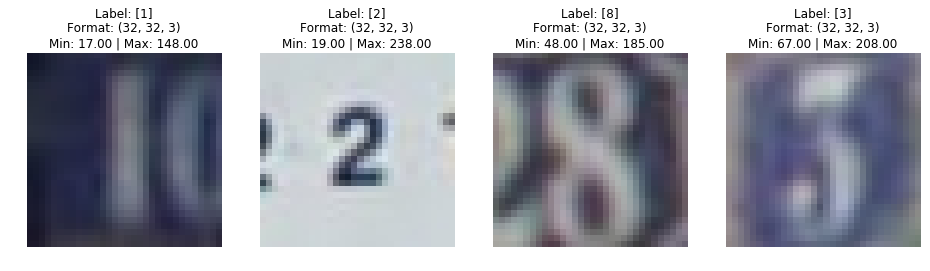

In [58]:
def display_sample_images(features, labels, n, normalized=False):
    fig = plt.figure(figsize=(16, 16))
    for i in range(n):
        plt.subplot(1,n,i + 1)
        image_num = np.random.randint(0, high=len(labels))
        if normalized:
            sample_image = np.squeeze(features[image_num], axis=2)
        else:
            sample_image = features[:,:,:,image_num]
        sample_label = labels[image_num]
        plt.axis('off')
        plt.title('Label: {}\nFormat: {}\nMin: {:.2f} | Max: {:.2f}'.format(sample_label,
                                                                    sample_image.shape,
                                                                    sample_image.min(),
                                                                    sample_image.max()))
        plt.imshow(sample_image)
    plt.show()

display_sample_images(features, labels, 4)

## Preprocessing

### Normalize features

In [59]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    n = x.shape[3]
    result = []
    for i in range(n):
        image = np.mean(x[:,:,:,i], axis=2)
        image = (image - np.mean(image)) / np.std(image)
        image = image[:,:,np.newaxis]
        print('Normalizing image #{:5d} | shape {}'.format(i, image.shape), end='\r')
        result.append(image)
    return np.array(result)

#features = normalize(features)
#print('\n', features.shape, sep='')

In [60]:
def global_contrast_normalization(x, s, lmda, epsilon):
    n = x.shape[3]
    result = []
    for i in range(n):
        image = x[:,:,:,i]
        image = image - np.mean(image)
        
        contrast = np.sqrt(lmda + np.mean(image**2))
        image = s * image / max(contrast, epsilon)
        print('Normalizing image #{:5d} | shape {}'.format(i, image.shape), end='\r')
        result.append(image)
    return np.array(result)
    
#features = global_contrast_normalization(features, 1, 10, 0.000000001)
#print('\n', features.shape, sep='')

In [61]:
def hog_normalization(x):
    n = x.shape[3]
    result = []
    start = time.time()
    for i in range(n):
        image = x[:,:,:,i]
        image = rgb2gray(image)
        _, image = hog(image, visualise=True)
        image = image[:,:,np.newaxis]
        print('Normalizing image #{:5d} | shape {} | time per image {:.4f} seconds'.format(i, image.shape, (time.time() - start) / (i + 1.0)), end='\r')
        result.append(image)
    return np.array(result)

features = hog_normalization(features)
print('\n', features.shape, sep='')

Normalizing image #73256 | shape (32, 32, 1) | time per image 0.0063 seconds
(73257, 32, 32, 1)


### One-hot encode labels

In [62]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    result = []
    start = time.time()
    for i in range(len(x)):
        print('Encoding label #{:5d} | time per image {:.4f} seconds'.format(i, (time.time() - start) / (i + 1.0)), end='\r')
        result.append([1 if x[i] == j + 1 else 0 for j in range(10)])
    return np.array(result)

labels = one_hot_encode(labels)
print('\n', labels.shape, sep='')

Encoding label #73256 | time per image 0.0002 seconds
(73257, 10)


### Split train and test set

In [63]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=0)

print('Train features: {}, train labels: {}'.format(X_train.shape, y_train.shape))
print('Test features: {}, test labels: {}'.format(X_test.shape, y_test.shape))

Train features: (54942, 32, 32, 1), train labels: (54942, 10)
Test features: (18315, 32, 32, 1), test labels: (18315, 10)


### Sanity check


Train set:


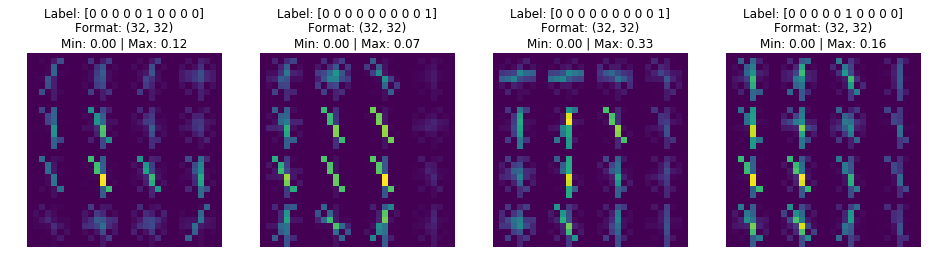


Test set:


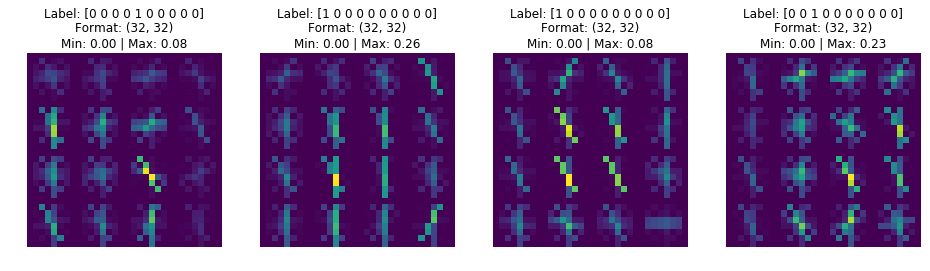

In [64]:
print('\nTrain set:')
display_sample_images(X_train, y_train, 4, normalized=True)

print('\nTest set:')
display_sample_images(X_test, y_test, 4, normalized=True)

## Building the Neural Net

### Building nodes, weights, biases

In [65]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides, scope='conv'):
    
    with tf.variable_scope(scope):
        # Dimension parameters
        input_depth    = x_tensor.get_shape().as_list()[3]
        conv_height    = conv_ksize[0]
        conv_width     = conv_ksize[1]
        strides_height = conv_strides[0]
        strides_width  = conv_strides[1]
        padding        = 'SAME'
        
        # Initiate weights and biases
        W = tf.Variable(tf.truncated_normal([conv_height, conv_width, input_depth, conv_num_outputs], stddev=0.01))
        b = tf.Variable(tf.zeros([conv_num_outputs]))
        
        # Draw convnet
        output = tf.nn.conv2d(x_tensor, W, [1, strides_height, strides_width, 1], padding)
        output = tf.nn.bias_add(output, b)
        output = tf.nn.relu(output)
        
        return output

In [66]:
def maxpool(x_tensor, pool_ksize, pool_strides, scope='pool'):
    
    with tf.variable_scope(scope):
        # Max pool parameters
        pool_height    = pool_ksize[0]
        pool_width     = pool_ksize[1]
        pool_strides_h = pool_strides[0]
        pool_strides_w = pool_strides[1]
        padding        = 'SAME'
        
        # Maxpool
        output = tf.nn.max_pool(x_tensor,
                                ksize=[1, pool_height, pool_width, 1],
                                strides=[1, pool_strides_h, pool_strides_w, 1],
                                padding=padding)
        
        return output

In [67]:
def flatten(x_tensor, scope='flat'):
    
    with tf.variable_scope(scope):
        height = x_tensor.get_shape().as_list()[1]
        width  = x_tensor.get_shape().as_list()[2]
        depth  = x_tensor.get_shape().as_list()[3]
        return tf.reshape(x_tensor,[-1, height * width * depth])

In [68]:
def fully_conn(x_tensor, num_outputs, keep_prob=None, scope='fc'):
    
    with tf.variable_scope(scope):
        W = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[1], num_outputs], stddev=0.01))
        b = tf.Variable(tf.zeros([num_outputs]))
        fc = tf.nn.relu(tf.matmul(x_tensor, W) + b)
        if keep_prob is not None:
            fc = tf.nn.dropout(fc, keep_prob)
        return fc

In [69]:
def output(x_tensor, num_outputs, scope='output'):
    with tf.variable_scope(scope):
        W = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[1], num_outputs], stddev=0.01))
        b = tf.Variable(tf.zeros([num_outputs]))
        return tf.matmul(x_tensor, W) + b

### VGG16 neural net layout

In [70]:
x = tf.placeholder(tf.float32, (None, features.shape[1], features.shape[2], features.shape[3]), 'x')
y = tf.placeholder(tf.float32, (None, labels.shape[1]), 'y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# VGG16 architecture

# 1st conv layer
conv1_1 = conv2d(x,64,(3, 3),(1, 1), scope='conv1_1')
conv1_2 = conv2d(conv1_1,64,(3, 3),(1, 1), scope='conv1_2')
poll1 = maxpool(conv1_2,(2, 2),(2, 2), 'pool1')

# 2nd conv layer
conv2_1 = conv2d(poll1,128,(3, 3),(1, 1), scope='conv2_1')
conv2_2 = conv2d(conv2_1,128,(3, 3),(1, 1), scope='conv2_2')
pool2 = maxpool(conv2_2,(2, 2),(2, 2), 'pool2')

# 3rd conv layer
conv3_1 = conv2d(pool2,256,(3, 3),(1, 1), scope='conv3_1')
conv3_2 = conv2d(conv3_1,256,(3, 3),(1, 1), scope='conv3_2')
conv3_3 = conv2d(conv3_2,256,(3, 3),(1, 1), scope='conv3_3')
pool3 = maxpool(conv3_3,(2, 2),(2, 2), 'pool3')

# 3rd conv layer
conv4_1 = conv2d(pool3,512,(3, 3),(1, 1), scope='conv4_1')
conv4_2 = conv2d(conv4_1,512,(3, 3),(1, 1), scope='conv4_2')
conv4_3 = conv2d(conv4_2,512,(3, 3),(1, 1), scope='conv4_3')
pool4 = maxpool(conv4_3,(2, 2),(2, 2), 'pool4')

# 3rd conv layer
conv5_1 = conv2d(pool4,512,(3, 3),(1, 1), scope='conv5_1')
conv5_2 = conv2d(conv5_1,512,(3, 3),(1, 1), scope='conv5_2')
conv5_3 = conv2d(conv5_2,512,(3, 3),(1, 1), scope='conv5_3')
pool5 = maxpool(conv5_3,(2, 2),(2, 2), 'pool5')

# Fully connected layer
flat = flatten(pool5, scope='flat')
fc1   = fully_conn(flat, 4096, keep_prob=keep_prob, scope='fc1')
fc2   = fully_conn(fc1, 4096, keep_prob=keep_prob, scope='fc2')

# Logits output
logits = output(fc2, labels.shape[1], scope='logits')

### Loss and optimizer

In [71]:
with tf.name_scope('train'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

### Accuracy

In [72]:
with tf.name_scope('prediction'):
    prediction = tf.argmax(logits, 1)

with tf.name_scope('accuracy'):
    correct_pred = tf.equal(prediction,(tf.argmax(y, 1)))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Training the neural net

In [73]:
def batch_creator(features, labels, batch_size, val_size=None):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        if val_size is not None:
            feat_batch_train, feat_batch_val, lab_batch_train, lab_batch_val = train_test_split(features[start:end],
                                                                                                labels[start:end],
                                                                                                test_size=val_size)
            yield feat_batch_train, feat_batch_val, lab_batch_train, lab_batch_val
        else:
            yield features[start:end], labels[start:end]

In [74]:
epochs = 100
batch_size = 160
val_size = 0.2
train_keep_prob = 0.5
learn_rate = 0.01
display_step = 1

In [ ]:
init = tf.global_variables_initializer()

train_acc_results = []
val_acc_results = []
images_samples = []
loss = 0
train_acc = 0
val_acc = 0

with tf.Session() as sess:
    sess.run(init)
    tf.summary.FileWriter('/tmp/vgg', sess.graph)
    iteration = 1
    start = time.time()
    for epoch in range(epochs):
        for X_batch_train, X_batch_val, y_batch_train, y_batch_val in batch_creator(X_train, y_train, batch_size, val_size):
            train_feed_dict = {x: X_batch_train,
                               y: y_batch_train,
                               keep_prob: train_keep_prob,
                               learning_rate: learn_rate
                              }
            sess.run(optimizer, feed_dict=train_feed_dict)
            loss += sess.run(cost, feed_dict=train_feed_dict)
            train_acc += sess.run(accuracy, feed_dict=train_feed_dict)
            
            val_feed_dict = {x: X_batch_val,
                             y: y_batch_val,
                             keep_prob: 1.0
                            }
            val_acc += sess.run(accuracy, feed_dict=val_feed_dict)
            iteration += 1
        
        end = time.time()
        train_acc_results.append(train_acc / iteration * 1.)
        val_acc_results.append(val_acc / iteration * 1.)
        
        if epoch % display_step == 0 or epoch + 1 == epochs:
            print('Epoch {:4d}/{:4d}|Iteration {:5d} => \
loss:{:10.4f} | train: {:.4f} | val: {:.4f} | time per interation: {:.3f} seconds'.format(epoch,
                                                                                          epochs - 1, 
                                                                                          iteration,
                                                                                          loss / iteration * 1.,
                                                                                          train_acc / iteration * 1.,
                                                                                          val_acc / iteration * 1.,
                                                                                          (end - start) / iteration * 1.))
            
    rand_image = np.random.randint(0, high=len(X_train))
    sample_image = X_train[rand_image]
    plt.axis('off')
    plt.imshow(sample_image)
    plt.title('Sanity Check - Prediction on training data\nPrediction: {} | True: {}'.format(sess.run(prediction,
                                                                        feed_dict={x:X_train[rand_image].reshape((-1, 32, 32, 3)),
                                                                                   keep_prob:1.0
                                                                                  }),
                                                               np.where(y_train[rand_image] == 1)[0] + 1))
    plt.show()

Epoch    0/  99|Iteration   345 => loss:    2.2723 | train: 0.1902 | val: 0.1848 | time per interation: 0.737 seconds
Epoch    1/  99|Iteration   689 => loss:    2.2624 | train: 0.1898 | val: 0.1872 | time per interation: 0.738 seconds
Epoch    2/  99|Iteration  1033 => loss:    2.2553 | train: 0.1902 | val: 0.1858 | time per interation: 0.738 seconds
Epoch    3/  99|Iteration  1377 => loss:    2.2509 | train: 0.1903 | val: 0.1859 | time per interation: 0.738 seconds
Epoch    4/  99|Iteration  1721 => loss:    2.2478 | train: 0.1902 | val: 0.1860 | time per interation: 0.738 seconds
Epoch    5/  99|Iteration  2065 => loss:    2.2459 | train: 0.1900 | val: 0.1870 | time per interation: 0.738 seconds
Epoch    6/  99|Iteration  2409 => loss:    2.2446 | train: 0.1899 | val: 0.1877 | time per interation: 0.738 seconds
Epoch    7/  99|Iteration  2753 => loss:    2.2436 | train: 0.1896 | val: 0.1886 | time per interation: 0.738 seconds
Epoch    8/  99|Iteration  3097 => loss:    2.2427 | tra

In [ ]:
plt.plot(range(len(train_acc_results)), val_acc_results, label='Validation')
plt.plot(range(len(train_acc_results)), train_acc_results, label='Train')
plt.title('Train and Validation accuracy')
plt.legend()
plt.show()

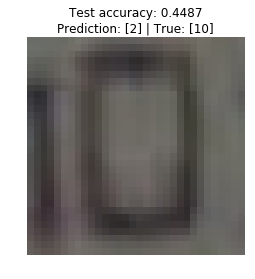

In [40]:
test_acc = 0
with tf.Session() as sess:
    sess.run(init)
    iteration = 1
    for X_batch_test, y_batch_test in batch_creator(X_test, y_test, batch_size):
        feed = {x: X_batch_test,
                y: y_batch_test,
                keep_prob: 1.0
               }
        test_acc += sess.run(accuracy, feed_dict=feed)
        iteration += 1
    
    rand_image = np.random.randint(0, high=len(X_test))
    sample_image = X_test[rand_image]
    plt.axis('off')
    plt.imshow(sample_image)
    plt.title('Test accuracy: {:.4f}\nPrediction: {} | True: {}'.format(test_acc / iteration * 1.,
                                                                        sess.run(prediction,
                                                                                 feed_dict={x:X_test[rand_image].reshape((-1, 32, 32, 3)),
                                                                                            keep_prob:1.0
                                                                                           }),
                                                                        np.where(y_test[rand_image] == 1)[0] + 1))
    plt.show()